In [1]:
from data_loader import *
import keras
from keras.models import Model, load_model
from keras import backend as K
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
data_file = "/datax/yzhang/training_data/training_data_chunk_14.pkl"
data_file2 = "/datax/yzhang/training_data/training_data_chunk_13.pkl"

CLASSES = ['16PSK', '2FSK_5KHz', '2FSK_75KHz', '8PSK', 'AM_DSB', 'AM_SSB', 'APSK16_c34',
 'APSK32_c34', 'BPSK', 'CPFSK_5KHz', 'CPFSK_75KHz', 'FM_NB', 'FM_WB',
 'GFSK_5KHz', 'GFSK_75KHz', 'GMSK', 'MSK', 'NOISE', 'OQPSK', 'PI4QPSK', 'QAM16',
 'QAM32', 'QAM64', 'QPSK']

COLORS = {
    '16PSK': '#e6194b', 
    '2FSK_5KHz': '#3cb44b', 
    '2FSK_75KHz': '#ffe119', 
    '8PSK': '#0082c8', 
    'AM_DSB': '#0082c8', 
    'AM_SSB':'#911eb4', 
    'APSK16_c34': '#46f0f0',
    'APSK32_c34': '#f032e6', 
    'BPSK': '#d2f53c', 
    'CPFSK_5KHz': '#fabebe', 
    'CPFSK_75KHz': '#008080', 
    'FM_NB': '#e6beff', 
    'FM_WB': '#aa6e28',
    'GFSK_5KHz': '#fffac8', 
    'GFSK_75KHz': '#800000', 
    'GMSK': '#aaffc3', 
    'MSK': '#808000', 
    'NOISE': '#ffd8b1', 
    'OQPSK': '#000080', 
    'PI4QPSK': '#808080', 
    'QAM16': '#0AC0E0',
    'QAM32': '#000000', 
    'QAM64': '#E00A19', 
    'QPSK': '#3BF703'}




testdata = LoadModRecData(data_file, 1., 0., 0., load_snrs=[10], num_samples_per_key=100)
train_data = testdata.signalData
train_labels = testdata.signalLabels[:,0]


testdata2 = LoadModRecData(data_file2, 1., 0., 0., load_snrs=[10], num_samples_per_key=100)
train_data2 = testdata2.signalData
train_labels2 = testdata2.signalLabels[:,0]

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 2400
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: FM

In [13]:
print(train_data.shape, train_labels.shape)
print(train_data2.shape, train_labels2.shape)

(2400, 2, 1024) (2400,)
(2400, 2, 1024) (2400,)


In [53]:
def tsne_model(model, data, layer_name=None, pca_dim=50, tsne_dim=2):
    """
    Does tsne reduction
    Parameters:
    model (keras model)
    data (np array): input data for the model
    layer_name: name of the output layer to do tsne on. 'None' will use 2nd to last layer, before final dense layer
 
    pca_dim (int): first dimensions are reduced using PCA to this number of dimensions
    tsne_dim (int): final desired dimension after doing tsne reduction
    
    Returns:
    np.array: Shape (data.shape[0], tsne_reduc); sample points in reduced space
    """
    
    if not layer_name:
        layer_name = model.layers[-2].name
    
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    
    intermediate_output = intermediate_layer_model.predict(data)
    
    pca = PCA(n_components= pca_dim, random_state = 214853)
    output_pca_reduced = pca.fit_transform(intermediate_output)
    
    tsne = TSNE(n_components=tsne_dim, random_state=214853)
    intermediates_tsne = tsne.fit_transform(output_pca_reduced)
    return intermediates_tsne


def tsne_plus_plot(model, data, labels, layer_name=None, pca_dim=50, tsne_dim= 2, mode = "train"):
    intermediates_tsne = tsne_model(model=model,data=data,layer_name=layer_name,pca_dim=pca_dim,tsne_dim=tsne_dim)
    unique_labels = np.unique(labels)
    
    color_intermediates = []
    for label in labels:
        color_intermediates.append(COLORS[label])
    color_intermediates = np.asarray(color_intermediates)

    plt.figure(figsize=(16, 16))
    for label in unique_labels:
        idx = np.where(labels == label)[0]
        plt.scatter(intermediates_tsne[idx,0], intermediates_tsne[idx,1], color=color_intermediates[idx], label=label)

    plt.legend()
    plt.show()


In [7]:
model = load_model('../../mod_group0_val_loss5754_copy.h5')

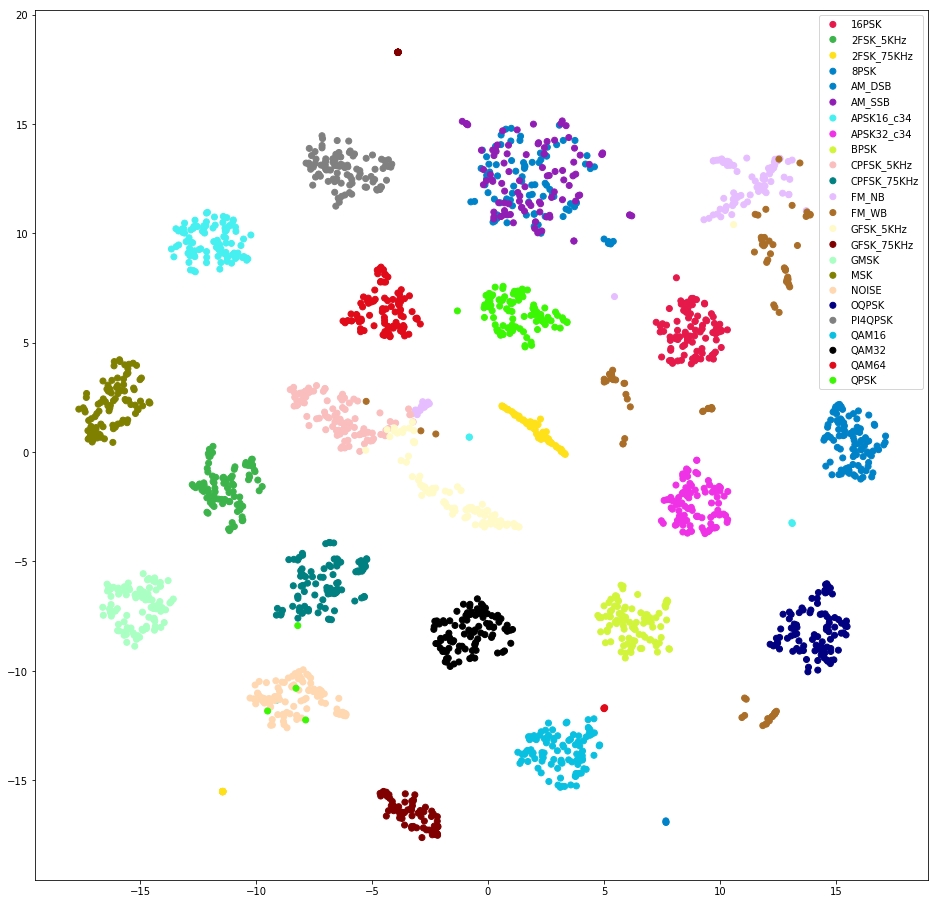

In [54]:
tsne_plus_plot(model, train_data, train_labels)

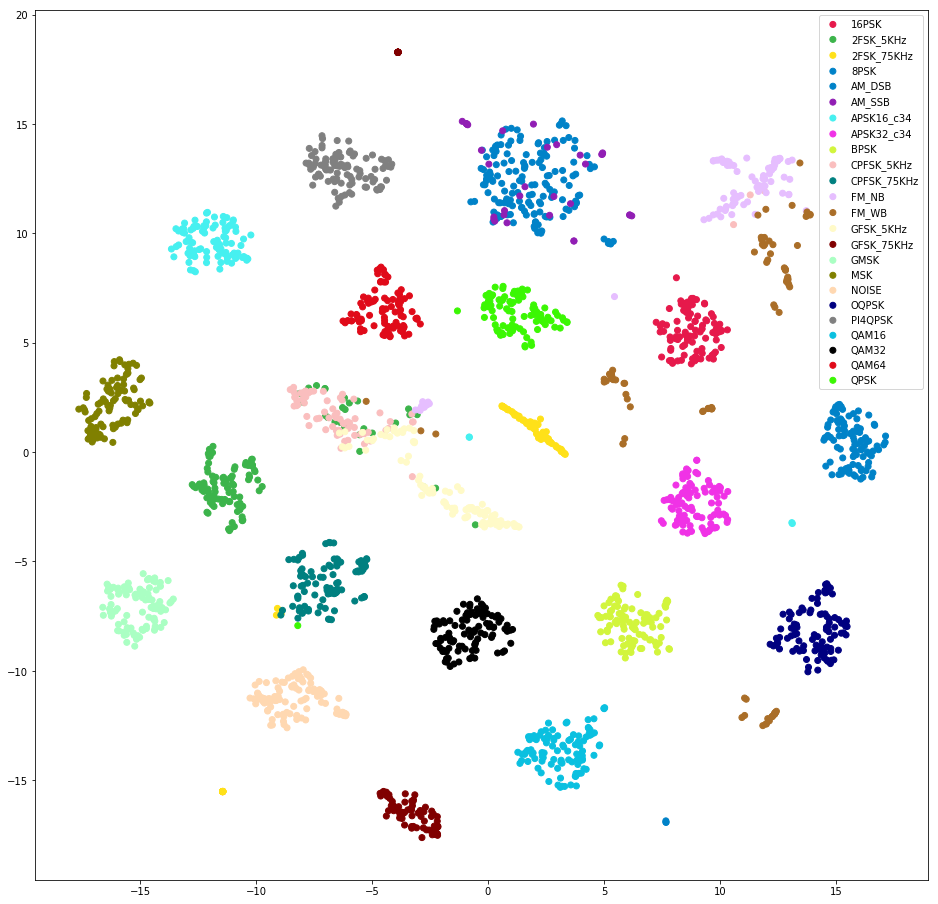

In [55]:
train_labels_predicted_probabilities = model.predict(train_data)
train_labels_predicted = np.asarray([CLASSES[np.argmax(pred)] for pred in train_labels_predicted_probabilities])
tsne_plus_plot(model, train_data, train_labels_predicted)

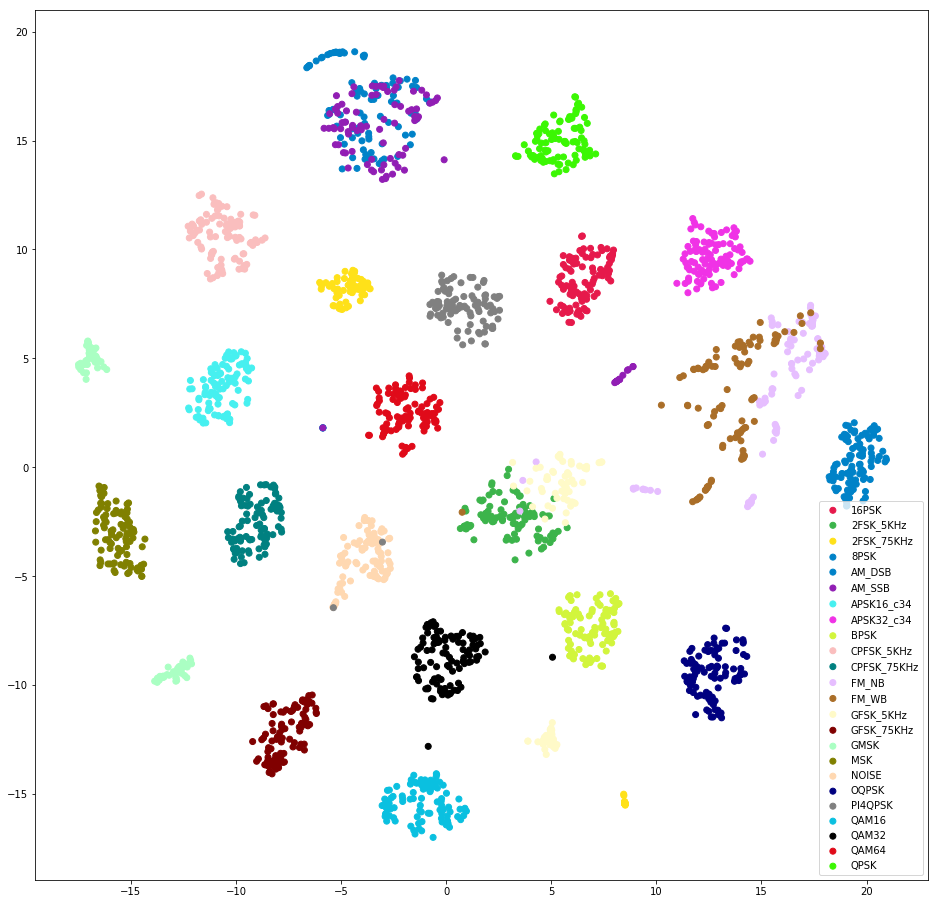

In [56]:
tsne_plus_plot(model, train_data2, train_labels2)

In [46]:
snr_model = load_model("../../snr2.h5")

In [26]:
test_file = "../../Test_Set_1_Army_Signal_Challenge.pkl"
test_file2 = "../../Test_Set_2_Army_Signal_Challenge.pkl"


In [63]:
# open test sets
f = open(test_file, 'rb')
testdata1 = pickle.load(f, encoding='latin1')
testdata1 = np.stack([testdata1[i] for i in range(1, len(testdata1.keys())+1)], axis=0)

f = open(test_file2, 'rb')
testdata2 = pickle.load(f, encoding='latin1')
testdata2 = np.stack([testdata2[i] for i in range(1, len(testdata2.keys())+1)], axis=0)


In [67]:
# get snr preds
snr_preds1 = np.asarray([np.argmax(snr_prob) for snr_prob in snr_model.predict(testdata1)])
snr_preds2 = np.asarray([np.argmax(snr_prob) for snr_prob in snr_model.predict(testdata2)])

In [70]:
# filter testsets
testdata1  = testdata1[np.where(snr_preds1 == 5)]
testdata2  = testdata2[np.where(snr_preds1 == 5)]

(100000, 2, 1024) (100000, 2, 1024)
(16583, 2, 1024) (16583, 2, 1024)


In [71]:
testdata1  = testdata1[np.random.choice(testdata1.shape[0], 2400, replace=False)]
testdata2  = testdata2[np.random.choice(testdata2.shape[0], 2400, replace=False)]

In [72]:
test1_preds = model.predict(testdata1)
test2_preds = model.predict(testdata2)

In [73]:
test1_labels = np.asarray([CLASSES[np.argmax(pred)] for pred in test1_preds])
test2_labels = np.asarray([CLASSES[np.argmax(pred)] for pred in test2_preds])

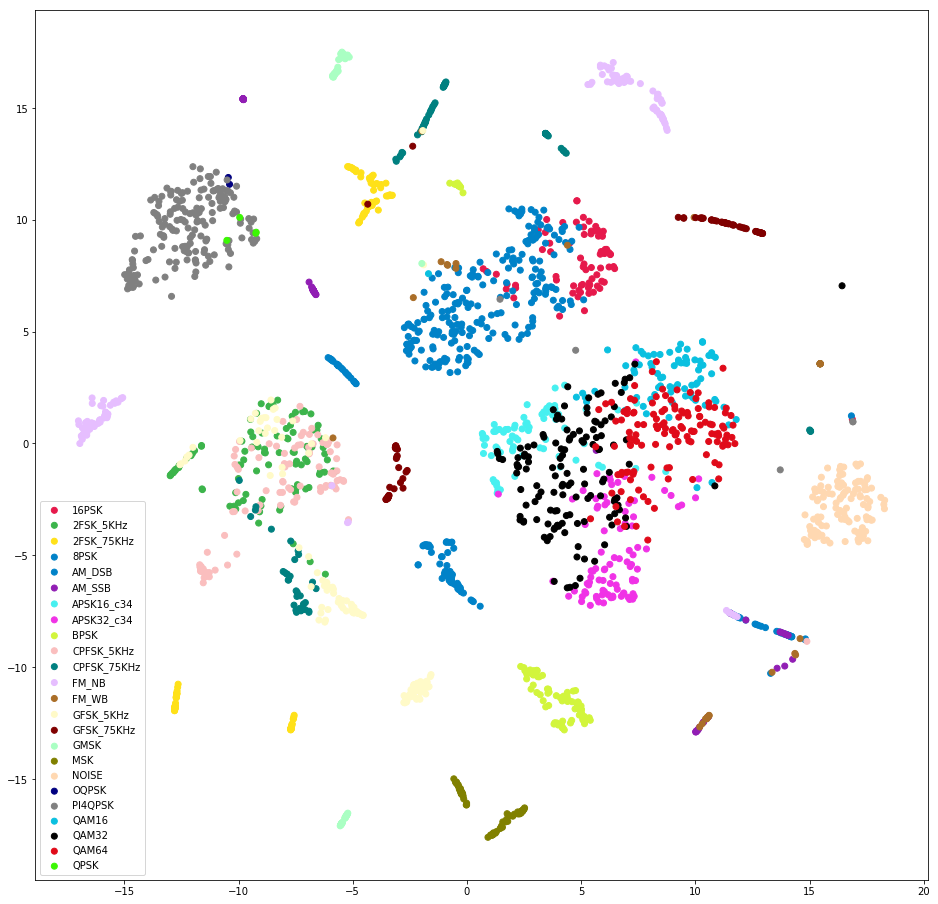

In [74]:
tsne_plus_plot(model, testdata1, test1_labels)

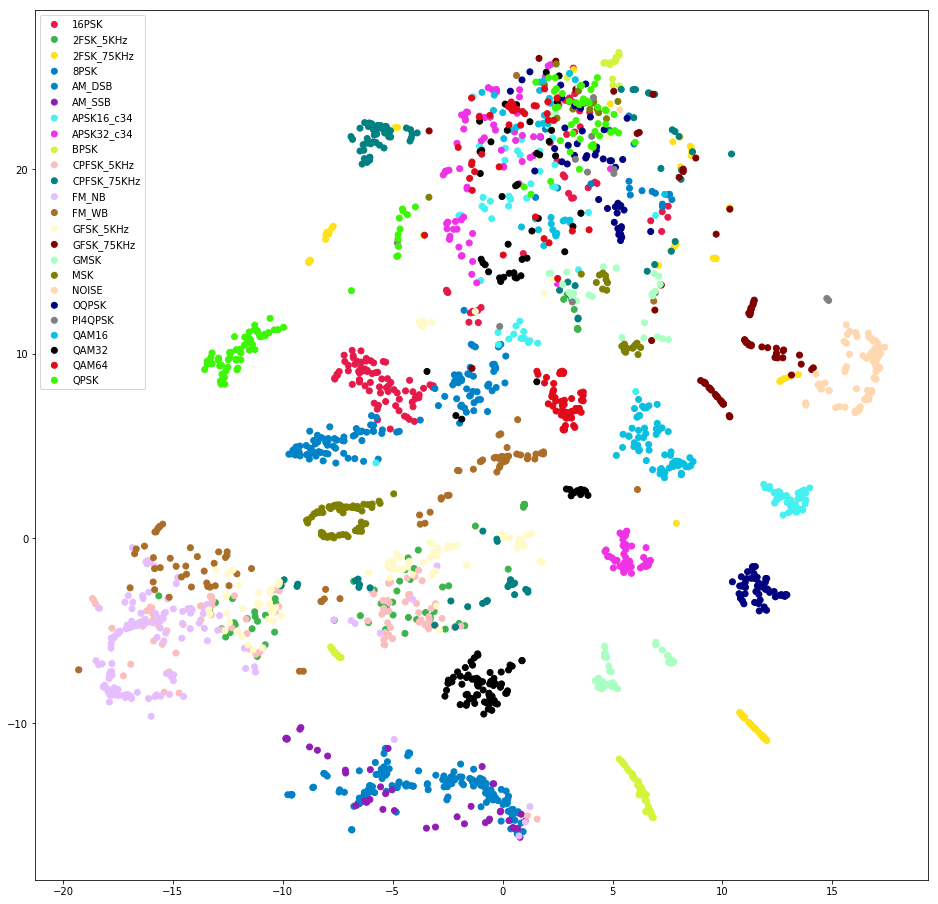

In [75]:
tsne_plus_plot(model, testdata2, test2_labels)